In [1]:
import os
import time
from dataclasses import dataclass
from typing import Optional

import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme(context='notebook', palette='Reds_r')

import yaml
import wandb
import numpy as np
import pandas as pd
from easydict import EasyDict as edict

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, CategoricalNB, ComplementNB
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, confusion_matrix, classification_report

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier


from paperswithtopic.config import load_config
from paperswithtopic.preprocess import Preprocess
from paperswithtopic.run import setup
from paperswithtopic.misc import seed_everything

In [2]:
cfg = load_config()
cfg.use_saved = True
cfg.pre_embed = False
cfg.use_bert_embed = False

# cfg.drop = []
seed_everything(seed=cfg.seed)

In [3]:
X, y, _, _ = setup(cfg, debug=True)
with open(os.path.join(cfg.DATA_DIR, 'column2idx.yml'), 'r') as f:
    column2idx = yaml.load(f)
idx2column = {v: k for k, v in column2idx.items()}

X_train, X_test, y_train, y_test = \
train_test_split(X, y, test_size=cfg.test_size, random_state=cfg.seed)

Load tokenized, without embeddings.
[load_data] 0.2 sec 
[tokenized_pipeline] 3.2 sec 


<ipython-input-3-04f99d176403>:3: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  column2idx = yaml.load(f)


In [4]:
@dataclass
class MultilabelTrainer:
    
    cfg: edict
    model_class: Optional
    X_train: np.ndarray
    y_train: np.ndarray
    idx2column: None
    verbose: bool = False
    kwargs = dict()
    
        
    def __post_init__(self):
        
        self.num_class = self.cfg.num_class
        self.models = dict()
       

    def run_all(self, X_train=None, y_train=None, X_test=None, y_test=None):
        
        if X_train is None:
            X_train = self.X_train
            
        if y_train is None:
            y_train = self.y_train
        
        if X_test is None or y_test is None:
            print('Validation set should be given')
            return
            
        self.fit()
        self.predict(X_test=X_test)
        self.get_auc(target=y_test)
        self.get_acc(target=y_test)
        self.chance_level()
        self.export_df()        

        
    def fit(self):
        
        for c in range(self.num_class):
            
            if self.idx2column is not None and self.verbose:
                print(f'Fit {idx2column[c].upper()}.')
            _model = self.model_class(**self.kwargs)
            _model.fit(self.X_train, self.y_train[:, c])
            self.models[c] = _model
            
            
    def predict(self, X_test):
        
        self.result = dict()
        for c in range(self.num_class):
            
            if self.idx2column is not None and self.verbose:
                print(f'Predict {idx2column[c].upper()}.')
            _y = self.models[c].predict(X_test)
            self.result[c] = _y
            
        return self.result
    
    
    def get_auc(self, target, pred=None):
        
        '''
        target: y_test (num_valid, num_class)
        pred  : in the form of dict with class: pred (num_valid,)
            - will be parsed into (num_valid, num_class) of ndarray
            - if not given, it will use the previous result saved in 
        
        Calculates both
        - overall AUC -> self.overall_auc
        - each class AUC -> self.auc
        '''
        
        self.auc = dict()
        if pred is None or isinstance(pred, dict):
            if hasattr(self, 'result'):
                pred = np.column_stack([*self.result.values()])            
            
            else:
                print('Please infer with valid/test data first.')
                
            
        for c in range(self.num_class):            
            self.auc[self.idx2column[c]] = roc_auc_score(target[:, c], pred[:, c])

        self.overall_auc = roc_auc_score(target, pred, multi_class='ovr')
        return self.overall_auc
    
    
    def get_acc(self, target, pred=None):
        
        '''
        Same with get_auc except that it does NOT return AUC
        '''
        
        self.acc = dict()
        if pred is None or isinstance(pred, dict):
            pred = np.column_stack([*self.result.values()])
            
        for c in range(self.num_class):
            self.acc[self.idx2column[c]] = accuracy_score(target[:, c], pred[:, c])
            
        return self.acc
    

    def chance_level(self, target=None):
        
        '''
        Calculate how many instances were in each class
        If target is not given, it will automatically use y_train.
        '''
        
        if target is None:
            target = self.y_train
            
        self.chance_level = dict()
        for c in range(self.num_class):
            self.chance_level[self.idx2column[c]] = target[:, c].sum() / len(target)
        
        return self.chance_level
    
    
    def export_df(self):
        
        '''
        possible feats
        'idx2column', 'result', 'auc', 'acc', 'chance_level'
        '''
        
        df = dict()
        self.feats = ['auc', 'acc', 'chance_level']
        for feat in self.feats:
            
            if hasattr(self, feat):
                df[feat] = getattr(self, feat)
        
        self.df = pd.DataFrame(df)
        return self.df
    
    
    def plot_acc_proportion(self, feats: list =None):
        
        if feats is None:
            feats = ['acc', 'chance_level']
            
        fig, ax = plt.subplots(figsize=(10, 8))
        ax.set_title(f'{self.model_class.__name__} Chance Level vs. Accuracy', size='large')
        ax.set_xlabel('Label Class', size='large')
        ax.set_ylabel('Proportion (%)', size='large')
        if not hasattr(self, 'df'):
            self.export_df()
        self.df[feats].plot(kind='bar', ax=ax)
        
        return ax

Working on GaussianNB.
Working on ComplementNB.
Working on LinearSVC.


C:\Users\pha\anaconda3\envs\xai501\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\pha\anaconda3\envs\xai501\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\pha\anaconda3\envs\xai501\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\pha\anaconda3\envs\xai501\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\pha\anaconda3\envs\xai501\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear fai

Working on RandomForestClassifier.
Working on ExtraTreesClassifier.
Working on AdaBoostClassifier.
Working on LGBMClassifier.
Working on XGBClassifier.
[22:50:04] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\pha\anaconda3\envs\xai501\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:50:07] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:50:10] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:50:15] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:50:19] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

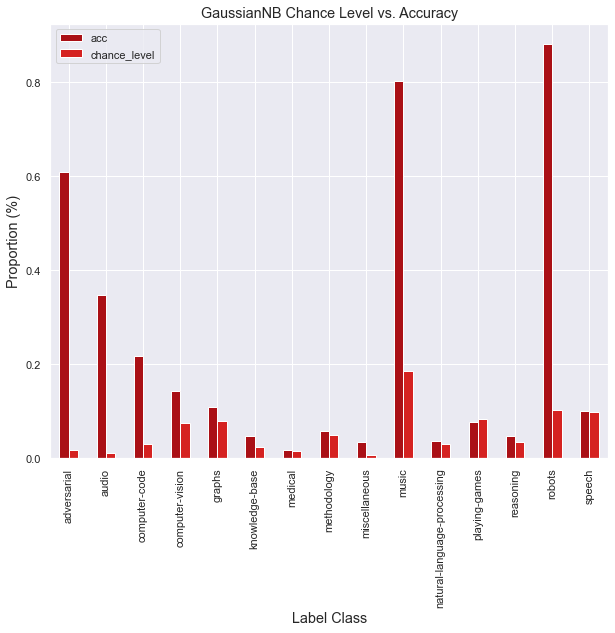

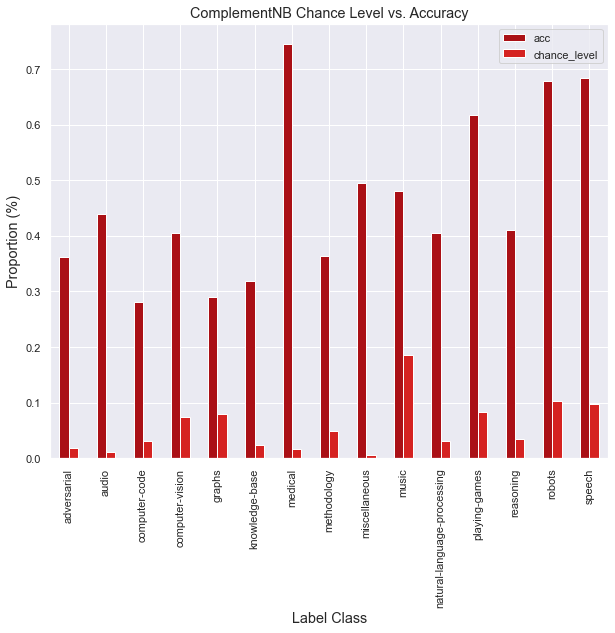

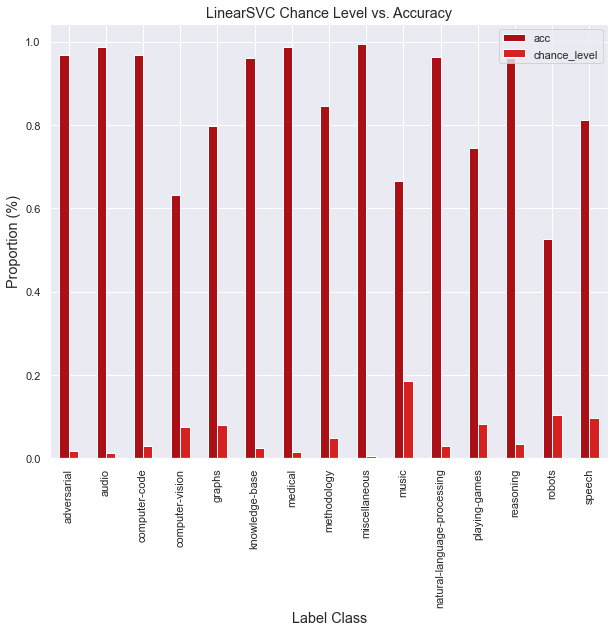

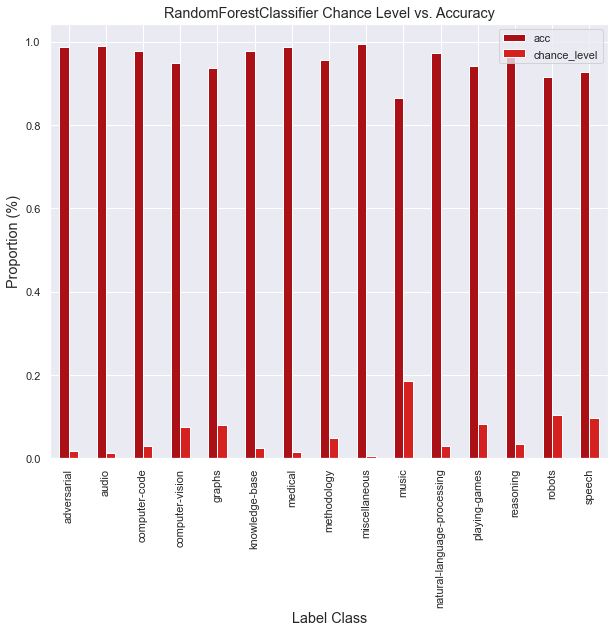

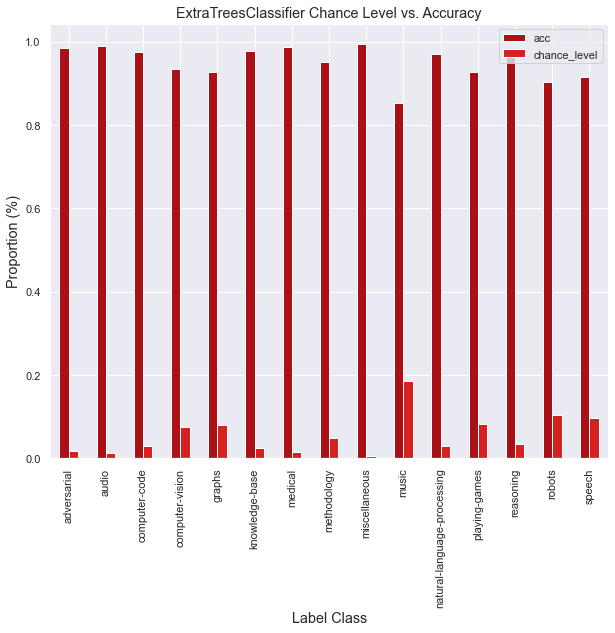

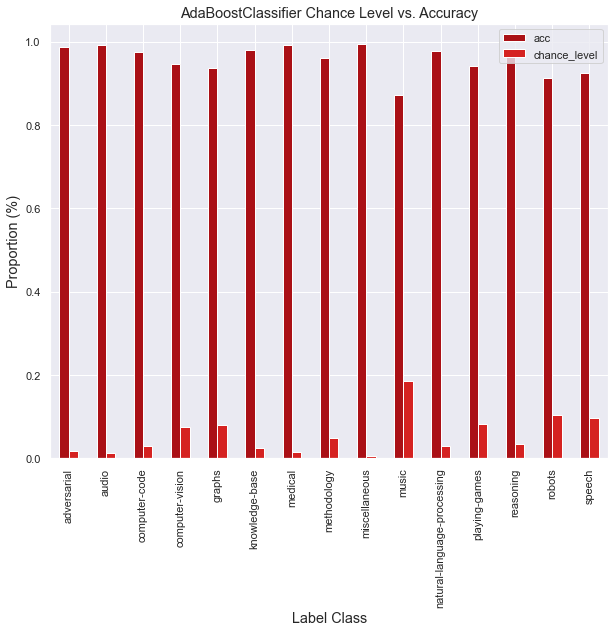

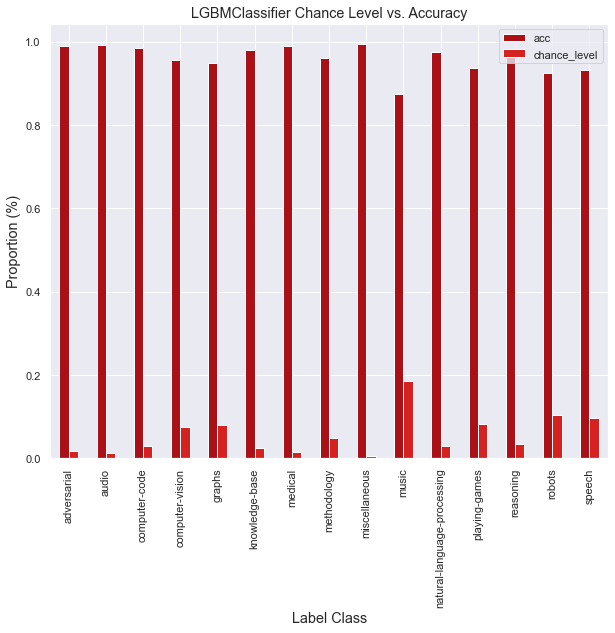

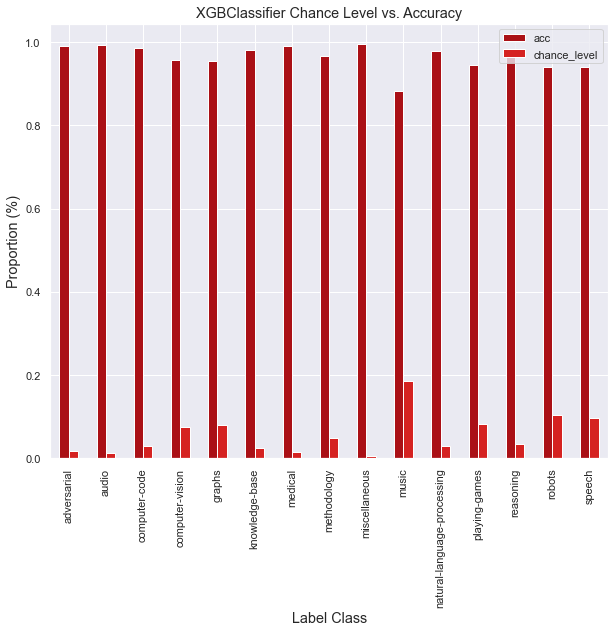

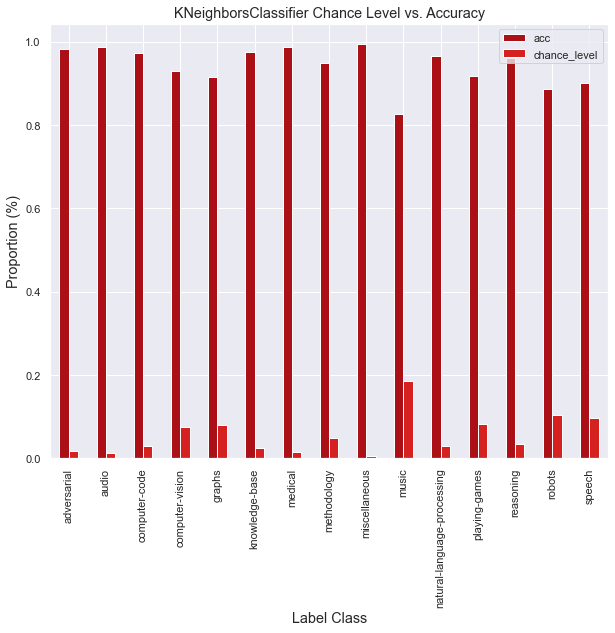

In [5]:
MODELS = [GaussianNB, ComplementNB, LinearSVC,\
         RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier,\
         LGBMClassifier, XGBClassifier, KNeighborsClassifier
     ]

trainers = dict()
for _model_class in MODELS:

    print(f'Working on {_model_class.__name__}.')
    trainer = MultilabelTrainer(cfg, _model_class, X_train, y_train, idx2column, verbose=False)
    trainer.run_all(X_test=X_test, y_test=y_test)
    trainer.plot_acc_proportion()
    trainers[_model_class.__name__] = trainer

In [6]:
idx2column = trainer.idx2column

In [7]:
for name, trainer in trainers.items():
    
    print(f'--- Model {name.upper()} ---')
    for c in range(cfg.num_class):
        print(f'{idx2column[c]}: {precision_score(y_test[:, c], trainer.result[c]):.3f}')

--- Model GAUSSIANNB ---
adversarial: 0.043
audio: 0.017
computer-code: 0.033
computer-vision: 0.085
graphs: 0.080
knowledge-base: 0.023
medical: 0.013
methodology: 0.050
miscellaneous: 0.007
music: 0.262
natural-language-processing: 0.032
playing-games: 0.077
reasoning: 0.038
robots: 0.160
speech: 0.101
--- Model COMPLEMENTNB ---
adversarial: 0.021
audio: 0.009
computer-code: 0.029
computer-vision: 0.084
graphs: 0.084
knowledge-base: 0.026
medical: 0.021
methodology: 0.055
miscellaneous: 0.007
music: 0.189
natural-language-processing: 0.036
playing-games: 0.092
reasoning: 0.035
robots: 0.113
speech: 0.131
--- Model LINEARSVC ---
adversarial: 0.118
audio: 0.000
computer-code: 0.000
computer-vision: 0.059
graphs: 0.025
knowledge-base: 0.000
medical: 0.000
methodology: 0.067
miscellaneous: 0.000
music: 0.227
natural-language-processing: 0.000
playing-games: 0.075
reasoning: 0.000
robots: 0.102
speech: 0.125
--- Model RANDOMFORESTCLASSIFIER ---
adversarial: 0.931
audio: 1.000
computer-cod

C:\Users\pha\anaconda3\envs\xai501\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [8]:
for name, trainer in trainers.items():
    
    print(f'--- Model {name.upper()} ---')
    for c in range(cfg.num_class):
        print(f'{idx2column[c]}')
        print(classification_report(y_test[:, c], trainer.result[c]))

--- Model GAUSSIANNB ---
adversarial
              precision    recall  f1-score   support

           0       1.00      0.60      0.75      4910
           1       0.04      0.99      0.08        88

    accuracy                           0.61      4998
   macro avg       0.52      0.80      0.42      4998
weighted avg       0.98      0.61      0.74      4998

audio
              precision    recall  f1-score   support

           0       1.00      0.34      0.51      4941
           1       0.02      0.98      0.03        57

    accuracy                           0.35      4998
   macro avg       0.51      0.66      0.27      4998
weighted avg       0.99      0.35      0.50      4998

computer-code
              precision    recall  f1-score   support

           0       1.00      0.20      0.33      4864
           1       0.03      0.99      0.06       134

    accuracy                           0.22      4998
   macro avg       0.52      0.59      0.20      4998
weighted avg     


playing-games
              precision    recall  f1-score   support

           0       0.93      0.63      0.75      4615
           1       0.09      0.45      0.15       383

    accuracy                           0.62      4998
   macro avg       0.51      0.54      0.45      4998
weighted avg       0.87      0.62      0.71      4998

reasoning
              precision    recall  f1-score   support

           0       0.96      0.40      0.57      4810
           1       0.03      0.55      0.07       188

    accuracy                           0.41      4998
   macro avg       0.50      0.48      0.32      4998
weighted avg       0.92      0.41      0.55      4998

robots
              precision    recall  f1-score   support

           0       0.90      0.73      0.80      4466
           1       0.11      0.29      0.16       532

    accuracy                           0.68      4998
   macro avg       0.50      0.51      0.48      4998
weighted avg       0.81      0.68      0.7

C:\Users\pha\anaconda3\envs\xai501\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.97      1.00      0.99      4839
           1       0.88      0.18      0.30       159

    accuracy                           0.97      4998
   macro avg       0.93      0.59      0.64      4998
weighted avg       0.97      0.97      0.96      4998

playing-games
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      4615
           1       0.88      0.26      0.40       383

    accuracy                           0.94      4998
   macro avg       0.91      0.63      0.68      4998
weighted avg       0.94      0.94      0.92      4998

reasoning
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      4810
           1       1.00      0.17      0.29       188

    accuracy                           0.97      4998
   macro avg       0.98      0.59      0.64      4998
weighted avg       0.97      0.97      0.96      4

              precision    recall  f1-score   support

           0       0.87      0.99      0.93      4072
           1       0.88      0.35      0.50       926

    accuracy                           0.87      4998
   macro avg       0.87      0.67      0.71      4998
weighted avg       0.87      0.87      0.85      4998

natural-language-processing
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      4839
           1       0.88      0.33      0.48       159

    accuracy                           0.98      4998
   macro avg       0.93      0.67      0.74      4998
weighted avg       0.98      0.98      0.97      4998

playing-games
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      4615
           1       0.84      0.29      0.43       383

    accuracy                           0.94      4998
   macro avg       0.89      0.64      0.70      4998
weighted avg       0.94      0.9

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      4839
           1       0.88      0.35      0.50       159

    accuracy                           0.98      4998
   macro avg       0.93      0.68      0.75      4998
weighted avg       0.98      0.98      0.97      4998

playing-games
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      4615
           1       0.89      0.31      0.46       383

    accuracy                           0.94      4998
   macro avg       0.92      0.65      0.71      4998
weighted avg       0.94      0.94      0.93      4998

reasoning
              precision    recall  f1-score   support

           0       0.97      1.00      0.99      4810
           1       0.90      0.28      0.43       188

    accuracy                           0.97      4998
   macro avg       0.94      0.64      0.71      4998
weighted avg       0.97      0.97      0.96      4

In [9]:
for name, trainer in trainers.items():
    
    print(f'--- Model {name.upper()} ---')
    print(classification_report(y_test, np.column_stack([*trainer.result.values()])))

--- Model GAUSSIANNB ---
              precision    recall  f1-score   support

           0       0.04      0.99      0.08        88
           1       0.02      0.98      0.03        57
           2       0.03      0.99      0.06       134
           3       0.08      0.99      0.16       398
           4       0.08      0.99      0.15       390
           5       0.02      1.00      0.05       114
           6       0.01      0.98      0.03        66
           7       0.05      1.00      0.10       249
           8       0.01      1.00      0.01        33
           9       0.26      0.04      0.06       926
          10       0.03      1.00      0.06       159
          11       0.08      1.00      0.14       383
          12       0.04      0.99      0.07       188
          13       0.16      0.03      0.05       532
          14       0.10      1.00      0.18       507

   micro avg       0.05      0.66      0.09      4224
   macro avg       0.07      0.87      0.08      4224
w

C:\Users\pha\anaconda3\envs\xai501\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\pha\anaconda3\envs\xai501\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [10]:
for name, trainer in trainers.items():
    
    print(f'--- Model {name.upper()} ---')
    print(f'{trainer.overall_auc}')

--- Model GAUSSIANNB ---
0.542774332901846
--- Model COMPLEMENTNB ---
0.5254243562289507
--- Model LINEARSVC ---
0.5006815526822705
--- Model RANDOMFORESTCLASSIFIER ---
0.5967717415486857
--- Model EXTRATREESCLASSIFIER ---
0.5369175526851343
--- Model ADABOOSTCLASSIFIER ---
0.6382143969884811
--- Model LGBMCLASSIFIER ---
0.6677958554447876
--- Model XGBCLASSIFIER ---
0.6988925988694933
--- Model KNEIGHBORSCLASSIFIER ---
0.5452694100497505


In [11]:
ACC, AUC = dict(), dict()

In [12]:
for name, _trainer in trainers.items():
    
    ACC[name] = _trainer.acc
    AUC[name] = _trainer.auc

In [13]:
acc_df = pd.DataFrame(ACC)
acc_df['Chance Level'] = _trainer.chance_level.values()

<ipython-input-14-4ac37975b476>:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([0.0, 20.0, 40.0, 60.0, 80.0, 100.0])


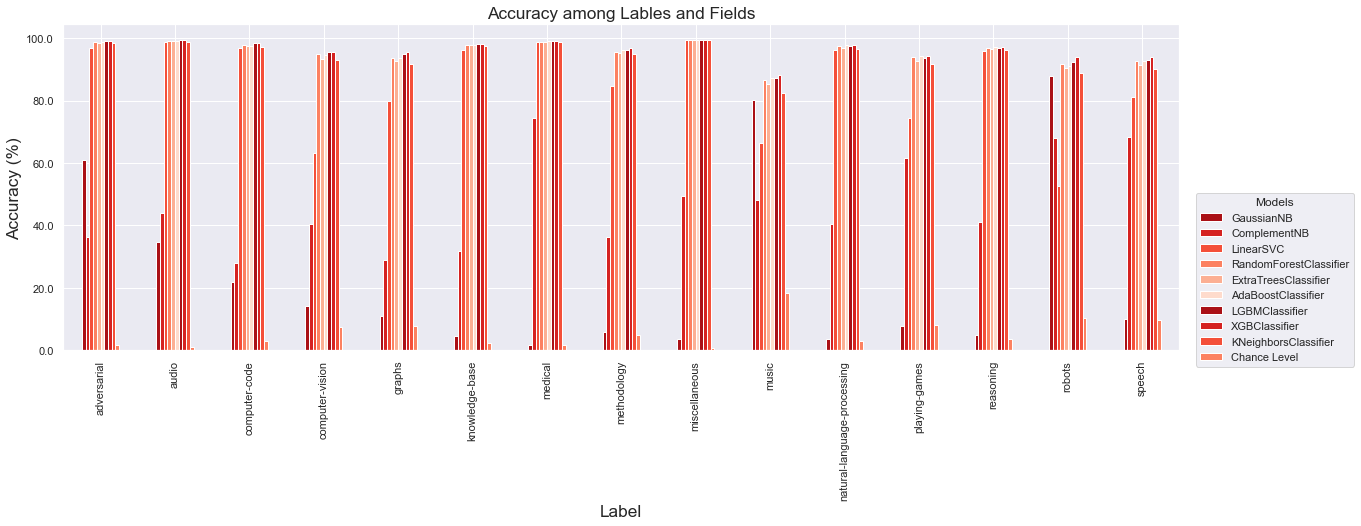

In [14]:
fig, ax = plt.subplots(figsize=(20, 6))
ax.set_title("Accuracy among Lables and Fields", size="x-large")
ax.set_xlabel("Label", size="x-large")
ax.set_ylabel("Accuracy (%)", size="x-large")
ax.set_yticklabels([0.0, 20.0, 40.0, 60.0, 80.0, 100.0])
acc_df.plot(kind='bar', ax=ax)
ax.legend(bbox_to_anchor=(1.01, 0.5), title="Models")

<ipython-input-15-c0c72d9de711>:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([0.0, 20.0, 40.0, 60.0, 80.0, 100.0], size='large')


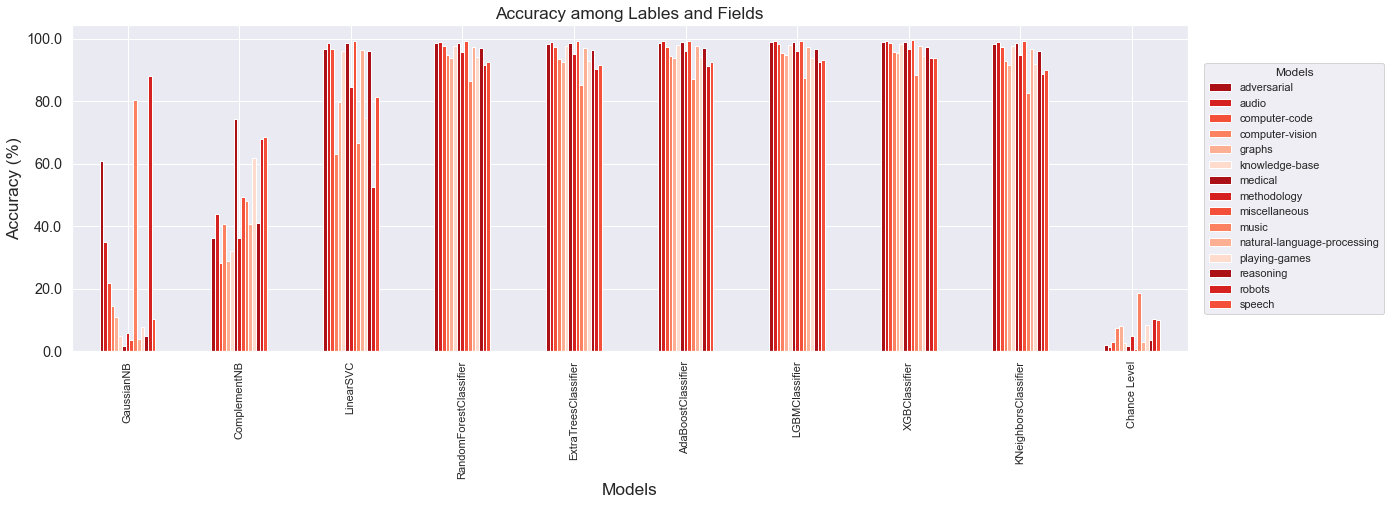

In [15]:
fig, ax = plt.subplots(figsize=(20, 6))
ax.set_title("Accuracy among Lables and Fields", size="x-large")
ax.set_xlabel("Models", size="x-large")
ax.set_ylabel("Accuracy (%)", size="x-large")
ax.set_yticklabels([0.0, 20.0, 40.0, 60.0, 80.0, 100.0], size='large')
acc_df.T.plot(kind='bar', ax=ax)
ax.legend(bbox_to_anchor=(1.01, 0.9), title="Models")

In [16]:
auc_df = pd.DataFrame(AUC)

<ipython-input-17-1cebd3414a5a>:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([f'{0.4 + i * 0.05:.2f}' for i in range(10)], size='large')


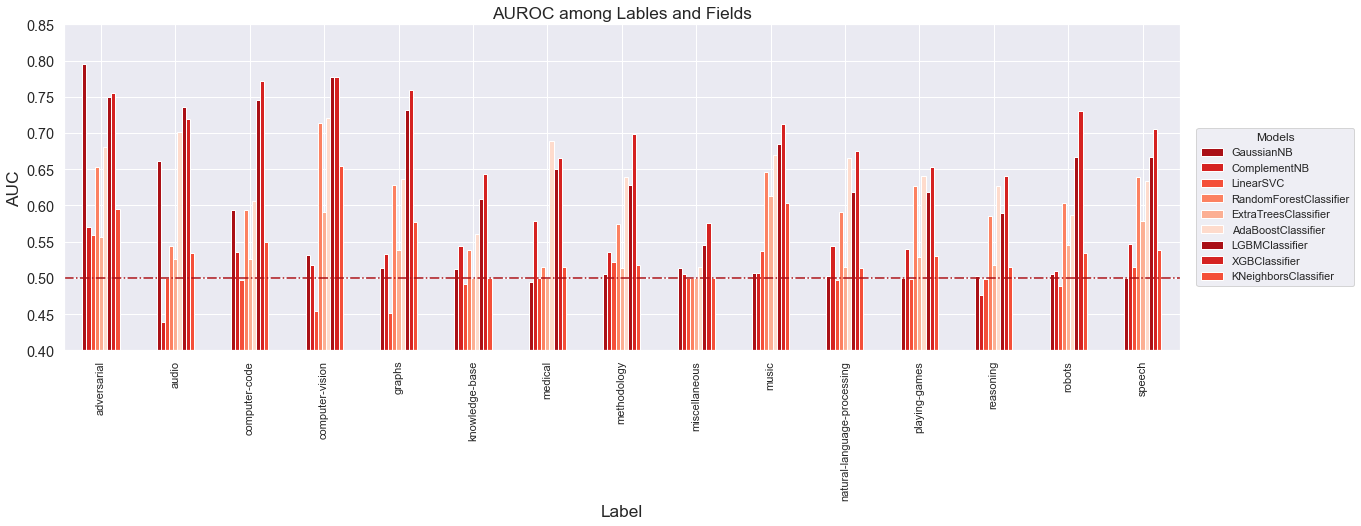

In [17]:
fig, ax = plt.subplots(figsize=(20, 6))
ax.set_title("AUROC among Lables and Fields", size="x-large")
ax.set_xlabel("Label", size="x-large")
ax.set_ylabel("AUC", size="x-large")
ax.set_yticklabels([f'{0.4 + i * 0.05:.2f}' for i in range(10)], size='large')
ax.axhline(0.5, linestyle='-.')
ax.set_ylim(0.4, 0.85)
auc_df.plot(kind='bar', ax=ax)
ax.legend(bbox_to_anchor=(1.01, 0.7), title="Models")

<ipython-input-18-3cd77f3cc4a1>:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([f'{0.4 + i * 0.05:.2f}' for i in range(10)], size='large')


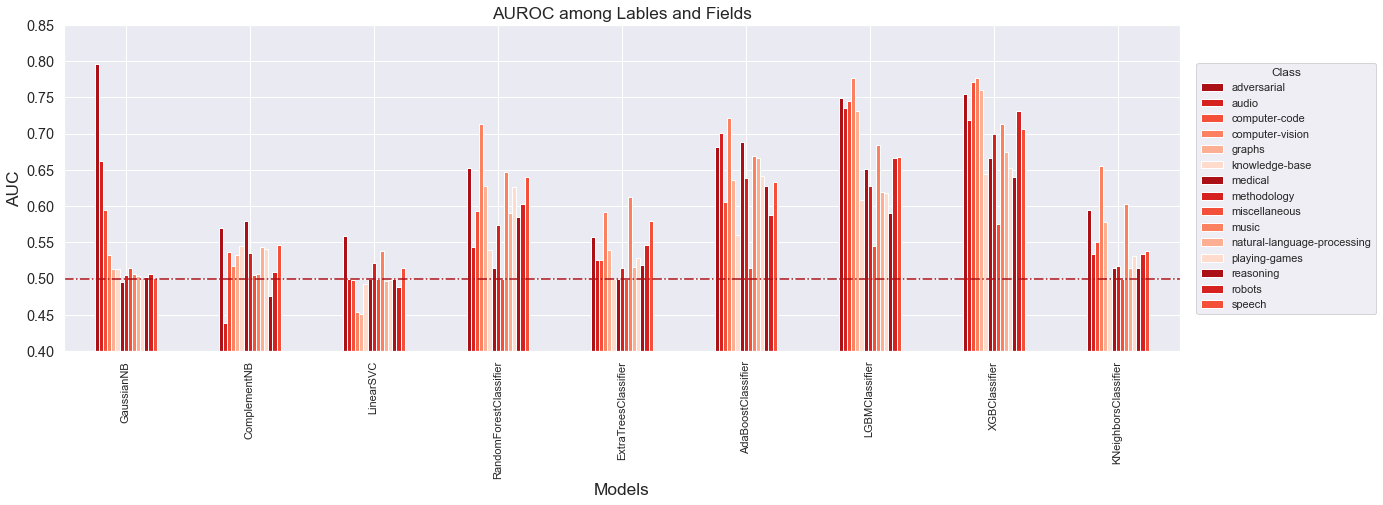

In [18]:
fig, ax = plt.subplots(figsize=(20, 6)) 
ax.set_title("AUROC among Lables and Fields", size="x-large")
ax.set_xlabel("Models", size="x-large")
ax.set_ylabel("AUC", size="x-large")
ax.tick_params(axis='x', labelrotation=45)
ax.set_yticklabels([f'{0.4 + i * 0.05:.2f}' for i in range(10)], size='large')
ax.axhline(0.5, linestyle='-.')
ax.set_ylim(0.4, 0.85)
auc_df.T.plot(kind='bar', ax=ax)
ax.legend(bbox_to_anchor=(1.01, 0.9), title="Labels")